In [2]:
import matplotlib.pyplot as plt
from Algorithm import Anomaly_detection, ShowUtil, TrainUtil
import numpy as np
import json
import random
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn import neighbors
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
from Algorithm import Util
import time as timer

In [3]:
# Inicializando sistema

def read_dataset(path):
    json_file = open(path)
    plt_content = json.load(json_file)
    json_file.close()
    return  plt_content

plt_content = read_dataset('database/database.json')
bars = [*range(1, 40)]
timestamp = plt_content["timestamp"]
data_size = plt_content["data_size"]

In [4]:
# Normalizando o sinal por blocos

def process_dataset (dataset, time_window):
    processed_dataset = {}
    max_time = round(max(timestamp))

    for simulation_name in dataset:

        if simulation_name not in processed_dataset:
            processed_dataset[simulation_name] = {}

        selected_simulation = plt_content['dataset'][simulation_name]
        [fault_type, fault_removal, from_bar, to_bar, time_start, time_end, Rc, Xc, LR, LQ] = Util.get_info(simulation_name)

        for key in selected_simulation:

            if key not in processed_dataset[simulation_name]:
                processed_dataset[simulation_name][key] = {}

            for time in range(0, max_time, time_window): 
                time_segment, data_segment = Util.segment_data(timestamp, selected_simulation[key], time, time+time_window)

                if time_start >= time and time_end <= time+time_window:
                    processed_dataset[simulation_name]['timestamp'] = time_segment
                    processed_dataset[simulation_name][key]['raw_data'] = data_segment
                    if 'parameter' in processed_dataset[simulation_name][key]:
                        processed_dataset[simulation_name][key]['previous_flag'] = True
                    else:
                        processed_dataset[simulation_name][key]['previous_flag'] = False
                else:
                    parameters = Anomaly_detection.calc_parameters([data_segment])
                    processed_dataset[simulation_name][key]['parameter'] = parameters

                if 'raw_data' in processed_dataset[simulation_name][key] and 'parameter' in processed_dataset[simulation_name][key]:
                    raw_data = processed_dataset[simulation_name][key]['raw_data']
                    parameter = processed_dataset[simulation_name][key]['parameter']
                    processed_data = Anomaly_detection.calc_distance([raw_data], parameter)
                    processed_dataset[simulation_name][key]['processed_data'] = processed_data

                    break

    return processed_dataset

processed_dataset = process_dataset(plt_content['dataset'], 10)

13.000011444091797


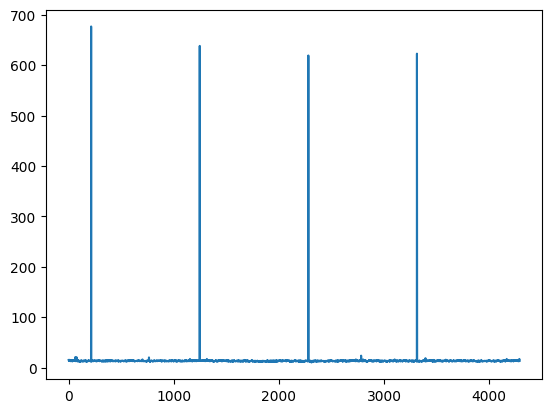

In [18]:
delta_list = []

count = 0

# Geração de graficos para a dissertação

def detect_anomaly(data, threshold):
    start = timer.time()
    data_t = [[value] for value in data]
    clf = OneClassSVM(kernel = 'linear', gamma = 'auto').fit(data_t)
    dist = clf.decision_function(data_t)

    anomaly = np.zeros(len(data), dtype=int)
    anomaly[dist <= threshold ] = 1
    end = timer.time()
    delta_list.append((end-start))

    if 1 in anomaly:
        return True
    else:
        return False

for data_name in plt_content['dataset']:
    if count > 10:
        break
    for bar_selected in plt_content['dataset'][data_name]:
        data = plt_content['dataset'][data_name][bar_selected]

        delta_time = 10
        max_time = round(max(timestamp))

        for time in range(0, max_time, delta_time): 
            time_segment, data_segment = Util.segment_data(timestamp, data, time, time+delta_time)
            detect_anomaly(data_segment, -2.2)
                # parameters = Anomaly_detection.calc_parameters([previous_data])
                # processed_data = Anomaly_detection.calc_distance([data_segment], parameters)

                # fig1, ax11 = plt.subplots()
                # ax11.plot(time_segment, data_segment, c='b')
                # plt.grid()
                # plt.xlabel('Tempo (segundos)')
                # plt.ylabel('Módulo da tensão (PU)')

                # fig1.savefig(f"images/data_segmented.png")

                # fig2, ax21 = plt.subplots()
                # ax21.plot(time_segment, processed_data, c='b')
                # plt.grid()
                # plt.xlabel('Tempo (segundos)')
                # plt.ylabel('Módulo da tensão processado')

                # fig2.savefig(f"images/data_processed.png")
                
            previous_data = data_segment
            previous_time = time_segment
    count += 1
    
print(np.median(delta_list))
plt.plot(delta_list)
plt.show()



In [ ]:
data = processed_dataset['APCB_RMCB;10_0.03;18_None;1.07_1.42;-1_23']

signal = []
bars = []
bar = 1
for key in data:
    if key !='timestamp':
        content = data[key]['processed_data']
        signal.append(content[4])
        bars.append(bar)
        bar += 1

fig1, ax11 = plt.subplots()
ax11.plot(bars, signal, c='b')
plt.grid()
plt.xlabel('Barras com PMU instalada')
plt.ylabel('Módulo da tensão (pré processado)')

fig1.savefig(f"images/perfil_tensao.png")

In [ ]:
# Curva ROC algoritmo de detecção de anomalias
def detect_anomaly(data):
    data_t = [[value] for value in data]
    clf = OneClassSVM(kernel = 'linear', gamma = 'auto').fit(data_t)
    limiar = clf.decision_function(data_t)

    return limiar


def predict_using_threshold(limiar_detected, threshold):
    limiar_detected = np.array(limiar_detected)
    pred_class = np.ones(len(limiar_detected), dtype=int)
    pred_class[limiar_detected < threshold] = 0

    return pred_class


def calc_results(multiplier, dataset):
    data_counter = 1
    limiar_detected = []
    label = []

    for simulation_name in dataset:

        print(f'Multiplier - {multiplier}: {simulation_name} - {(data_counter/data_number)*100}%')
        data_counter += 1


        selected_simulation = plt_content['dataset'][simulation_name]
        [fault_type, fault_removal, from_bar, to_bar, time_start, time_end, Rc, Xc, LR, LQ] = Util.get_info(simulation_name)
        for key in selected_simulation:

            data = np.array(selected_simulation[key])
            for time in range(0, max_time, delta_time): 
                time_segment, data_segment = Util.segment_data(timestamp, data, time, time+delta_time)
                limiar = detect_anomaly(data_segment)

                fault_mask = np.ones(len(time_segment), dtype=int)
                fault_mask[(time_start+0.01 <= time_segment) & (time_segment <= time_end+multiplier*(0.01))] = 0

                limiar_detected.extend(limiar)
                label.extend(fault_mask)

    auc = roc_auc_score(label, limiar_detected)
    fpr, tpr, thresholds = roc_curve(label, limiar_detected)



    fp_list = []
    fn_list = []
    thr_list = np.linspace(-5, 0, 20)
    for limiar in thr_list:
        pred_label = predict_using_threshold(limiar_detected, limiar)
        tn, fp, fn, tp = confusion_matrix(label, pred_label).ravel()

        fp_list.append((fp/len(pred_label))*100)
        fn_list.append((fn/len(pred_label))*100)


    fig1, ax11 = plt.subplots()
    ax11.plot(fpr, tpr, label=f"Operacão normal x condição de falta (AUC = {round(auc, 3)})")
    ax11.plot([0, 1], [0, 1], "k--", label="Classificador aleatório (AUC = 0.5)")
    plt.grid()
    plt.xlabel('Taxa de falsos positivos')
    plt.ylabel('Taxa de verdadeiros positivos')
    fig1.savefig(f"images/ROC_Results/multiplier_{multiplier}_ROC_AUC_{round(auc, 3)}.png")

    # plt.show()

    fig2, ax21 = plt.subplots()
    ax21.plot(thr_list, fp_list, c='b', label='Falso positivo')
    plt.grid()
    plt.xlabel('Limiar')
    plt.ylabel('Taxa de falso positivo(%)')

    ax22 = ax21.twinx()
    ax22.plot(thr_list, fn_list, c='r', label='Falso negativo')
    plt.ylabel('Taxa de falso negativo(%)')

    fig2.savefig(f"images/ROC_Results/multiplier_{multiplier}_FNxFP.png")

    # plt.show()


delta_time = 10
max_time = round(max(timestamp))

fp_list = []
fn_list = []

threshold_list = np.linspace(-1, -5, 10)
dataset = plt_content['dataset']
data_number = len(dataset)


for multiplier in range(2, 5):
    calc_results(multiplier, dataset)



In [ ]:
# Treinamento do algoritmo de localização da falta

PMU_set = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 ,17 ,18 ,19, 20, 21, 22, 23, 24, 25 ,26 ,27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
score = TrainUtil.estimate_system_accuracy_location(processed_dataset, PMU_set)

print(score)



In [ ]:
while True:
    PMU_set = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15 , 16 ,17 ,18 ,19, 20, 21, 22, 23, 24, 25 ,26 ,27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


    train_data_list = []
    test_data_list = []
    train_label_list = []
    test_label_list = []

    clf = svm.SVC(kernel='linear', decision_function_shape='ovo')

    for fold in range(6):
        train_data, test_data, train_label, test_label = TrainUtil.select_train_test_set(processed_dataset, PMU_set)
        train_data_list.append(train_data)
        test_data_list.append(test_data)
        train_label_list.append(train_label)
        test_label_list.append(test_label)



    label_true = []
    label_pred = []

    while len(PMU_set) > 4:
        bar_score_list = []

        for n_bar in PMU_set:
            print(f'Removing bar {n_bar}')
            PMU_new_set = PMU_set.copy()
            PMU_new_set.remove(n_bar)
            PMU_new_set = [bar - 1 for bar in PMU_new_set]

            for train_data, test_data, train_label, test_label in zip(train_data_list, test_data_list, train_label_list, test_label_list):

                train_data = np.array(train_data)
                test_data = np.array(test_data)

                train_data_sel = train_data[:, PMU_new_set]
                test_data_sel = test_data[:, PMU_new_set]

                train_data_sel = train_data_sel.tolist()
                test_data_sel = test_data_sel.tolist()

                clf.fit(train_data_sel, train_label)
                result_label = clf.predict(test_data_sel)

                label_true.extend(test_label)
                label_pred.extend(result_label)

                    
            score = f1_score(label_true, label_pred, average='micro')
            bar_score_list.append([n_bar, score])


        def sort_func(e):
            return e[1]

        bar_score_list.sort(key=sort_func)


        [worst_bar, score] = bar_score_list[-1]

        PMU_set.remove(worst_bar)

        f = open("results_fix_set.txt", "a")
        f.write(f'{PMU_set} - {score}\n')
        f.close()

        

In [ ]:
# Anomaly detection without pré-processing (Threshold = -2.4)
def detect_anomaly(data, threshold):
    data_t = [[value] for value in data]

    clf = OneClassSVM(kernel = 'linear', gamma = 'auto').fit(data_t)

    mask = clf.decision_function(data_t)
    data_fault = data.copy()

    data_fault[mask > threshold] = np.nan

    return data_fault


delta_time = 10
max_time = round(max(timestamp))

fp_list = []
fn_list = []

threshold_list = np.linspace(-1, -5, 10)

dataset = plt_content['dataset']



for threshold in threshold_list:
    fp = 0
    fn = 0
    samples = 0
    data_counter = 0

    for simulation_name in dataset:
        # if data_counter > 0:
        #     break
        # data_counter +=1

        print(f'threshold=> {threshold} - {simulation_name}')

        selected_simulation = plt_content['dataset'][simulation_name]
        [fault_type, fault_removal, from_bar, to_bar, time_start, time_end, Rc, Xc, LR, LQ] = Util.get_info(simulation_name)
        for key in selected_simulation:

            data = np.array(selected_simulation[key])
            for time in range(0, max_time, delta_time): 
                time_segment, data_segment = Util.segment_data(timestamp, data, time, time+delta_time)
                segment_fault = detect_anomaly(data_segment, threshold=threshold)

                fault_mask = np.zeros(len(time_segment), dtype=bool)
                fault_mask[(time_start+0.01 <= time_segment) & (time_segment <= time_end+0.01)] = True

                samples += len(time_segment)

                for flag, value in zip(fault_mask, segment_fault):
                    if flag and np.isnan(value):
                        fn += 1
                
                for flag, value in zip(fault_mask, segment_fault):
                    if not flag and not np.isnan(value):
                        fp += 1

    fp_list.append((fp/samples)*100)
    fn_list.append((fn/samples)*100) 

plt.rcParams['figure.figsize'] = (19.2, 10.8)
plt.rcParams.update({'font.size': 10})

fig1, ax1 = plt.subplots()
ax1.plot(threshold_list, fp_list, c='b')
ax2 = ax1.twinx()
ax2.plot(threshold_list, fn_list, c='r')

plt.grid()
plt.xlabel('Limiar de detecção da falta')
plt.ylabel('Taxa (%)')

plt.show()

In [ ]:

# Alocação de PMUs algoritmo 2

while True:
    PMU_set = bars.copy()
    while len(PMU_set) >= 3:
        bar_score_list = []
        hash = random.getrandbits(128)
        for n_bar in PMU_set:
            PMU_new_set = PMU_set.copy()
            PMU_new_set.remove(n_bar)
            
            score = TrainUtil.estimate_system_accuracy_location(processed_dataset, PMU_new_set)
            bar_score_list.append([n_bar, score])

            f = open("Worst_PMU_test_results.txt", "a")
            f.write(f'|{hash}| - {n_bar} - {score}\n')
            f.close()
            
        def sort_func(e):
            return e[1]

        bar_score_list.sort(key=sort_func)

        [worst_bar, score] = bar_score_list[-1]

        aux_bar_score_list = []
        for bar_score in bar_score_list:
            if bar_score[1] == score:
                aux_bar_score_list.append(bar_score)

        index = random.randint(0, len(aux_bar_score_list)-1)


        PMU_set.remove(aux_bar_score_list[index][0])

        f = open("Best_results_test_location.txt", "a")
        f.write(f'|{hash}| - {PMU_set} - {score}\n')
        f.close()



In [ ]:
def DrawImage(bars, prob_list):

    refs_file = open("images/refs.json")
    refs = json.load(refs_file)

    image = Image.open("images/Diagram.png")
    draw = ImageDraw.Draw(image)

    fnt = ImageFont.truetype("fonts/arial.ttf", 12)

    for bar, prob in zip (bars, prob_list):
        begin = refs[f'{bar}']['begin']
        end = refs[f'{bar}']['end']
        draw.line([tuple(begin), tuple(end)], width=7, fill=(255, 0, 0, int(prob*255/100)))    
        draw.text((end[0]-5, end[1]+10), f'{round(prob, 1)}%', font=fnt,  align ="left", fill=(255, 0, 0))          
    image.show()

PMUs = [38, 37, 31, 33, 35, 32, 30]

label_set, result_proba, label_list = TrainUtil.estimate_system_prob_class(results_dict, PMUs)

for result, real_label in zip (result_proba, label_list):
    print(f"FALTA NA BARRA {real_label}")
    DrawImage(label_set, result)

In [ ]:
# Exibindo dados sem nenhum processamento
ShowUtil.plot_3d(plt_content, selected_key=['APCL_ABCI;45_0.03;9_39;1.45_0.85;-9_-18'], segment_fault=True)

In [ ]:
# Exibindo normalização para todas barras (sinal de tensão)
ShowUtil.plot_3d(results_dict, segment_fault=True)